In [1]:
import os
os.chdir("/Users/User/P2")
print(os.getcwd())

C:\Users\User\P2


In [2]:
import pandas as pd
import numpy as np 

#load the data
data = pd.read_csv("MST_chl_oc4me-cleaned.csv")
print(data.shape)
print(data.info())

(1640, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1640 non-null   object 
 1   MST_chl_oc4me  1640 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB
None


In [3]:
# ADF Test = testing if data is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['MST_chl_oc4me'])

def adfuller_test(MST_chl_oc4me):
    result=adfuller(MST_chl_oc4me)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(data['MST_chl_oc4me'])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -4.33887662225932
p-value : 0.00038017047010781855
#Lags Used : 25
Number of Observations : 1614


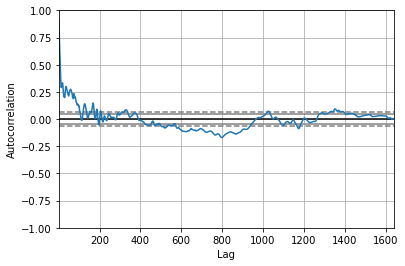

In [4]:
#autocorrelation

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline

autocorrelation_plot(data['MST_chl_oc4me'])
plt.show()

In [5]:
#divide into train and validation set
train = data[:int(0.7*(len(data)))]
valid = data[int(0.7*(len(data))):]

#preprocessing (since arima takes univariate series as input)
train.drop('Date',axis=1,inplace=True)
valid.drop('Date',axis=1,inplace=True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


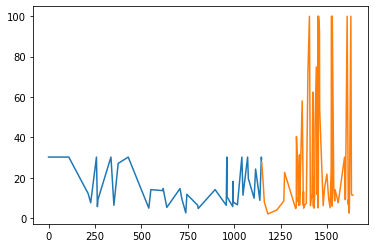

In [6]:
#plotting the data

train['MST_chl_oc4me'].plot()
valid['MST_chl_oc4me'].plot()

In [7]:
#building the model (with optimal p,d,q value)
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_fit=model.fit(train)

model_fit



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3293.424, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3365.098, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3292.549, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3302.956, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3363.099, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3291.596, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3293.585, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3291.434, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3291.094, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3291.603, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3292.418, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3289.094, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3300.957, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3290.551, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]          

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1148
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1641.547
Date:                Tue, 18 Jan 2022   AIC                           3289.094
Time:                        00:58:08   BIC                           3304.229
Sample:                             0   HQIC                          3294.808
                               - 1148                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4802      0.030     15.958      0.000       0.421       0.539
ma.L1         -0.2477      0.032     -7.818      0.000      -0.310      -0.186
sigma2         1.0247      0.008    122.829      0.000       1.008       1.041
===================================================================================
Ljung-Box (Q):                      183.85   Jarque-Bera (JB):           2454006.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.94   Skew:                            -7.37
Prob(H) (two-sided):                  0.00   Kurtosis:                       229.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

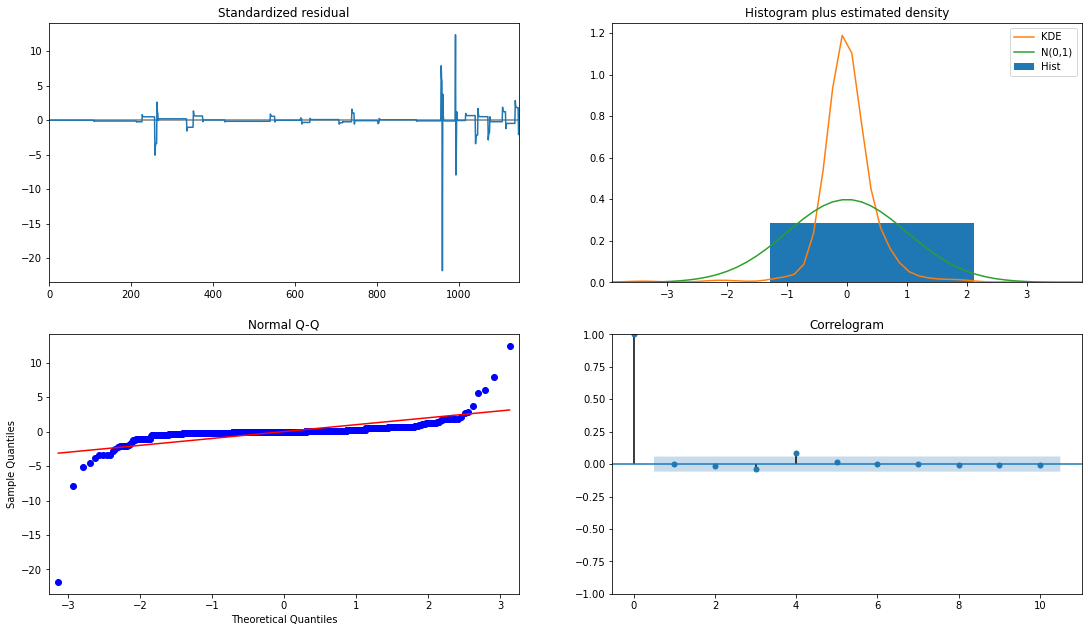

In [10]:
fig = model_fit.plot_diagnostics()
fig.set_size_inches(18.5, 10.5)

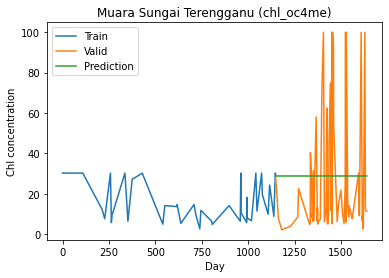

In [11]:
#plot the predictions for validation set

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.xlabel("Day")
plt.ylabel("Chl concentration")
plt.legend(loc="upper left")
plt.title("Muara Sungai Terengganu (chl_oc4me)")
plt.show()

In [12]:
#model evaluation
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import r2_score


print('Mean Absolute Error:', metrics.mean_absolute_error(valid,forecast))
print('Mean Squared Error:', metrics.mean_squared_error(valid,forecast))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(valid,forecast)))
print('R Squared value:',r2_score(valid,forecast))

Mean Absolute Error: 20.34157394778907
Mean Squared Error: 584.5134090013472
Root Mean Squared Error: 24.176712121406155
R Squared value: -0.10115870629062407
